## Importing the relevant modules

In [290]:
import gensim
import gensim.corpora as corpora
import pyLDAvis
import pyLDAvis.gensim_models
from scipy.spatial.distance import cdist
from sklearn.metrics.pairwise import cosine_similarity
from gensim.models import CoherenceModel
import pandas as pd
from scipy.spatial import KDTree
import random
from copkmeans.cop_kmeans import cop_kmeans
from sklearn.metrics import silhouette_score
import pickle, re
import os
import matplotlib.pyplot as plt
from skstab import StadionEstimator
from sklearn.cluster import KMeans
import numpy as np
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from palmettopy.palmetto import Palmetto
palmetto = Palmetto()
import warnings
import matplotlib.cm as cm
from sklearn.utils import shuffle
from sklearn.utils import check_random_state
from nltk.stem import *
from nltk.corpus import stopwords
ENG_STOP = stopwords.words("ENGLISH")
warnings.filterwarnings("ignore", category=DeprecationWarning)
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import spacy
from eval_utils import *
from features_utils import *
import matplotlib.pyplot as plt
from sklearn.decomposition import TruncatedSVD
from collections import defaultdict
from scipy.spatial.distance import euclidean
from keybert import KeyBERT
from sentence_transformers import SentenceTransformer

## Loading the saved LDA model

In [291]:
stemmer = porter.PorterStemmer()
nlp = spacy.load("en_core_web_sm")

In [292]:
cleaned_data = pickle.load(open("cleaned_data_130622_F.pkl","rb"))

In [293]:
optimal_model = gensim.models.LdaModel.load("Model_130622\model_3")

In [295]:
raw_dt = pd.read_pickle("Raw_Df_130622")

In [297]:
Data = pd.read_pickle("Data130622_F")

In [298]:
# def get_tfidf(text,max_features):
#     vectorizer = TfidfVectorizer(lowercase=False,max_features=max_features,ngram_range=(1,3))
#     bow = vectorizer.fit_transform(text)
#     text_d = bow.toarray()
#     temp = pd.DataFrame(text_d, columns = vectorizer.get_feature_names())
#     return temp
tfidf = get_tfidf([" ".join(doc) for doc in cleaned_data ],max_features=1000)

## Choosing a Random Document in the Corpus and Generating a corpus of K-Nearest Neighbors(Documents)


In [299]:
random_q = random.randint(0,1470)
kdB = KDTree(tfidf.values)
NN = kdB.query(tfidf.values, k=200)[-1][random_q]
NN = NN.tolist()

In [301]:
raw_dt = raw_dt.iloc[NN,:]
cd = [cleaned_data[i] for i in NN]
Data = Data.iloc[NN,:]
cleaned_data = cd.copy()

## Generating Topic Probabilities for the Selected Documents the Trained LDA Model

In [304]:
cleaned_data = pickle.load(open("cleaned_data_130622_F.pkl","rb"))

In [305]:
id2word = corpora.Dictionary(cleaned_data)
texts = cleaned_data
corpus = [id2word.doc2bow(text) for text in texts]

In [306]:
optimal_model.num_topics
topics_list = []

topic_prob = pd.DataFrame(columns = ["topic_"+str(i) for i in range(optimal_model.num_topics)])
for doc in NN:
    #print(doc)
    topics = optimal_model.get_document_topics(corpus[doc], minimum_probability=np.finfo(float).eps)
    topic_prob.loc[len(topic_prob)] = list([i[1] for i in topics])
    topics = sorted(topics,key=lambda x:x[1], reverse=True)
    topics_list.append(topics[0][0])

In [967]:
# def get_bow(text,max_features):
#     vectorizer = CountVectorizer(lowercase=False,max_features=max_features,ngram_range=(1,3))
#     bow = vectorizer.fit_transform(text)
#     text_d = bow.toarray()
#     temp = pd.DataFrame(text_d, columns = vectorizer.get_feature_names())
#     return temp

# def get_tfidf(text,max_features):
#     vectorizer = TfidfVectorizer(lowercase=False,max_features=max_features,ngram_range=(1,3))
#     bow = vectorizer.fit_transform(text)
#     text_d = bow.toarray()
#     temp = pd.DataFrame(text_d, columns = vectorizer.get_feature_names())
#     return temp

## Creating NxN Cosine Similarity Matrix using Topic Probabilities

In [309]:
Data["LDA"] = topics_list

In [308]:
## get cosine of the topic probabilities
cosine_array = cosine_similarity(topic_prob)
similarity_df = pd.DataFrame(columns=[(i) for i in range(len(Data))])
for doc in cosine_array:
    similarity_df.loc[len(similarity_df)] = list(doc)

##  Developing Constraints using Topic Probabilities

**Must-Link Constraints** Select the N largest most similar document pairs using the NxN Cosine Similarity Matrix. It is based on the simple assumption that the document with the most similar topic probabilites are likely to be taking about the most similar semantic(topic). Using probability means that the documents must not only agree on the dominant topic but **a) on the dissimilar topics b) on the degree similarity/dissimilarity**

**Cannot-Link Constraints**: Select the N largest most dissimilar document pairs using the NxN Cosine Similarity Matrix. It is based on the simple assumption that the document with the most dissimilar topic probabilites are likely to be poles apart in their semantics.

Here N is the hyperparameter which can be seen as a function of the size of a dataset. A general heuristic means the number should atleast be 10% of the size of the datset. For the same size of dataset this number- N augments(if high or reduces(if-low) the effect of the constarints in the clustering algorithm.

In [816]:
# Dummy Constraints to reecreate lda clustering. Useful for evaluation later
lda_ml_2 = [(i,j) for i in range(len(Data)) for j in range(i,len(Data)) if Data.iloc[i]["LDA"] == Data.iloc[j]["LDA"]]
lda_cl_2 =  [(i,j) for i in range(len(Data)) for j in range(i,len(Data)) if Data.iloc[i]["LDA"] != Data.iloc[j]["LDA"]]

KeyboardInterrupt: 

In [320]:
# def get_constraints(similarity_df, N)
#     n_ml = len(similarity_df) + N*2
#     n_cl = N*2
#     Top_vals = similarity_df.unstack().sort_values(ascending=False)[:n_ml]
#     Bottom_vals = similarity_df.unstack().sort_values(ascending=True)[:n_cl]
#     a =list(Top_vals.index.sort_values())
#     b = list(Bottom_vals.index.sort_values())
#     c = [(i,j) for (i,j) in a if i!=j]
#     cl = list(set([tuple(sorted(sub)) for sub in b]))
#     ml =list(set([tuple(sorted(sub)) for sub in c]))
#     return ml, cl


In [ ]:
ml, cl = get_constraints(similarity_df, 50)

### Feature Extraction using Singular Valued Decomposition

In [327]:
svd = TruncatedSVD(n_components=50, n_iter=7, random_state=42)
sv_dt = svd.fit_transform(Data)

In [328]:
np.sum(svd.explained_variance_ratio_)

0.9948085270473782

In [822]:
def get_silhouette_list(dt,cluster_dict):
    cluster_list = list(cluster_dict.values())
    num_k = list(cluster_dict.keys())
    sil_list = []
    for cl in cluster_list:
        s = silhouette_score(dt,cl)
        sil_list.append(s)
    return sil_list    

### Selection of Number of Clusters(K) using Stability Estimated Methods:

skstab API allows to build and tune a variety of stability estimation methods. Here the number of clusters are chosen based on Stadion: a novel stability-based validity index proposed by [Mourer et al, 2020 ](https://arxiv.org/abs/2006.08530)

Evaluated numbers of clusters: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
Stadion-max scores:
 [[0.04390426]
 [0.06936214]
 [0.14689222]
 [0.15607954]
 [0.14555894]
 [0.12865881]
 [0.13146853]
 [0.08155037]
 [0.06608112]
 [0.0703834 ]]
Selected number of clusters: K = 4


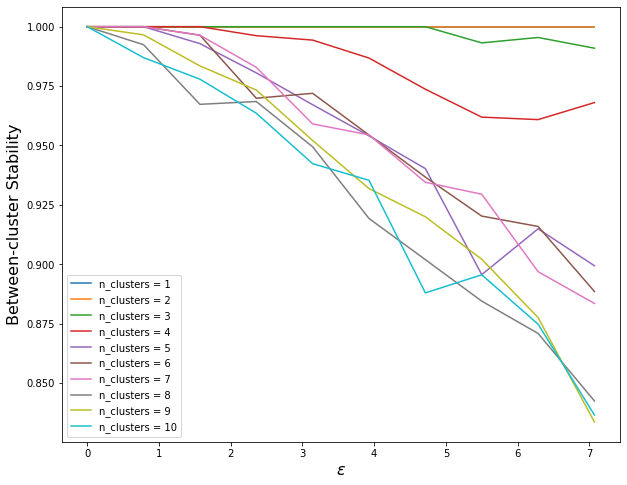

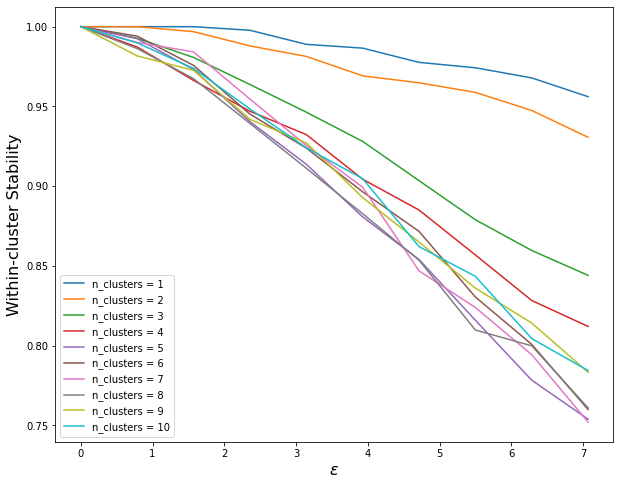

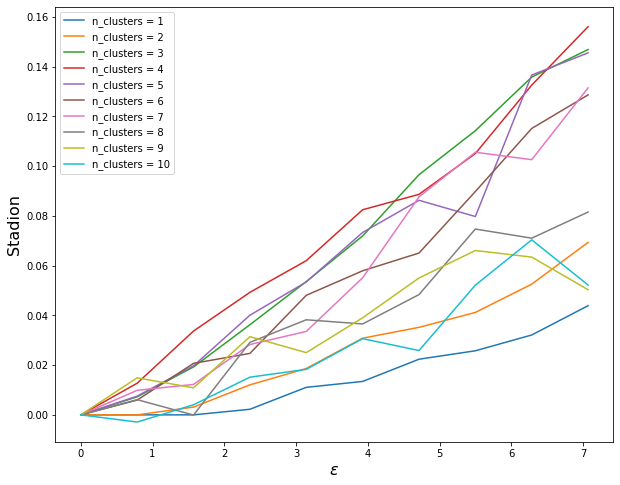

In [981]:
X = sv_dt
algorithm = KMeans
km_kwargs = {'init': 'k-means++', 'n_init': 10}
k_values = list(range(1, 11))
omega = list(range(2, 6))
print('Evaluated numbers of clusters:', k_values)
stab = StadionEstimator(X, algorithm,
                        param_name='n_clusters',
                        param_values=k_values,
                        omega=omega,
                        extended=True,
                        runs=10,
                        perturbation='uniform',
                        perturbation_kwargs='auto',
                        algo_kwargs=km_kwargs,
                        n_jobs=-1)

score = stab.score(strategy='max', crossing=True)
print('Stadion-max scores:\n', score)
k_hat = stab.select_param()[0]
print('Selected number of clusters: K =', k_hat)

"""
Generate plots
"""
# These are the "Tableau 20" colors as RGB.
tableau20 = [(31, 119, 180), (174, 199, 232), (255, 127, 14), (255, 187, 120),
             (44, 160, 44), (152, 223, 138), (214, 39, 40), (255, 152, 150),
             (148, 103, 189), (197, 176, 213), (140, 86, 75), (196, 156, 148),
             (227, 119, 194), (247, 182, 210), (127, 127, 127), (199, 199, 199),
             (188, 189, 34), (219, 219, 141), (23, 190, 207), (158, 218, 229)]
# Scale the RGB values to the [0, 1] range, which is the format matplotlib accepts.
for i in range(len(tableau20)):
    r, g, b = tableau20[i]
    tableau20[i] = (r / 255., g / 255., b / 255.)

plt.figure(figsize=(10, 8))
for i, p in enumerate(k_values):
    plt.plot(epsilons, stab.between_cluster_stability_paths[i, :, 0], label='{} = {}'.format(stab.param_name, p),
             color=tableau20[(2 * i) % 20])
plt.legend()
plt.xlabel('$\epsilon$', fontsize=16)
plt.ylabel('Between-cluster Stability', fontsize=16)
# plt.title('{} (dataset = {} / true K = {})'.format(algorithm.__name__, dataset, len(np.unique(y))), fontsize=16)
plt.savefig("1")

plt.figure(figsize=(10, 8))
for i, p in enumerate(k_values):
    plt.plot(epsilons, stab.within_cluster_stability_paths[i, :, 0], label='{} = {}'.format(stab.param_name, p),
             color=tableau20[(2 * i) % 20])
plt.legend()
plt.xlabel('$\epsilon$', fontsize=16)
plt.ylabel('Within-cluster Stability', fontsize=16)
# plt.title('{} (dataset = {} / true K = {})'.format(algorithm.__name__, dataset, len(np.unique(y))), fontsize=16)
plt.savefig("2")

plt.figure(figsize=(10, 8))
for i, p in enumerate(k_values):
    plt.plot(epsilons, stab.stadion_paths[i, :, 0], label='{} = {}'.format(stab.param_name, p),
             color=tableau20[(2 * i) % 20])
plt.legend()
plt.xlabel('$\epsilon$', fontsize=16)
plt.ylabel('Stadion', fontsize=16)
plt.savefig("3")


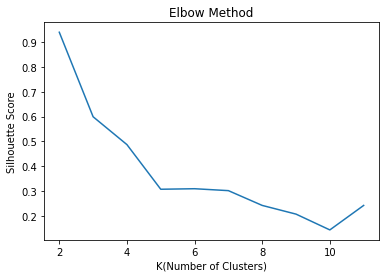

In [861]:
kmeans_cluster_dict = defaultdict(int)
for k in range(2,12):
    km = KMeans(k)
    km_dt = km.fit_transform(sv_dt)
    kmeans_clusters = list(km.predict(sv_dt))
    kmeans_cluster_dict[k] = kmeans_clusters
km_sil = get_silhouette_list(sv_dt,kmeans_cluster_dict)
plt.plot(list(kmeans_cluster_dict.keys()),km_sil,label='KMeans')
plt.xlabel('K(Number of Clusters)')
plt.ylabel('Silhouette Score')
plt.title("Elbow Method")
plt.savefig("4", bbox_inches='tight')

## Choice of Intitialization Techniques

**Empirical evaluation of the impact of k-means initialization**

Evaluate the ability of k-means initializations strategies to make the algorithm convergence robust as measured by the relative standard deviation of the inertia of the clustering (i.e. the sum of squared distances to the nearest cluster center).

The plot shows the best inertia reached for each combination
of the model (``KMeans``) and the init method
(``init="random"`` or ``init="kmeans++"``) for increasing values of the
``n_init`` parameter that controls the number of initializations.

[https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_stability_low_dim_dense.html
](https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_stability_low_dim_dense.html)
"""

Evaluation of KMeans with k-means++ init
Evaluation of KMeans with random init


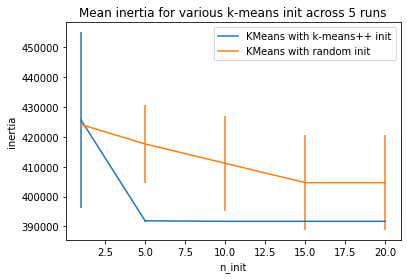

In [877]:
"""
============================================================
Empirical evaluation of the impact of k-means initialization
============================================================

Evaluate the ability of k-means initializations strategies to make
the algorithm convergence robust as measured by the relative standard
deviation of the inertia of the clustering (i.e. the sum of squared
distances to the nearest cluster center).

The plot shows the best inertia reached for each combination
of the model (``KMeans``) and the init method
(``init="random"`` or ``init="kmeans++"``) for increasing values of the
``n_init`` parameter that controls the number of initializations.


Citiation
---------
https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_stability_low_dim_dense.html
Author: Olivier Grisel <olivier.grisel@ensta.org>
License: BSD 3 clause

"""
random_state = np.random.RandomState(0)

# Number of run so as to be able to compute an estimate of the standard deviation
n_runs = 5

# k-means models can do several random inits so as to be able to trade
# CPU time for convergence robustness
n_init_range = np.array([1, 5, 10, 15, 20])
n_clusters = 4

# Quantitative evaluation of various init methods

plt.figure()
plots = []
legends = []

cases = [
    (KMeans, "k-means++", {}),
    (KMeans, "random", {}),
]

for factory, init, params in cases:
    print("Evaluation of %s with %s init" % (factory.__name__, init))
    inertia = np.empty((len(n_init_range), n_runs))

    for run_id in range(n_runs):
#         X, y = make_data(run_id, n_samples_per_center, grid_size, scale)
        X = sv_dt
        for i, n_init in enumerate(n_init_range):
            km = factory(
                n_clusters=n_clusters,
                init=init,
                random_state=run_id,
                n_init=n_init,
                **params,
            ).fit(X)
            inertia[i, run_id] = km.inertia_
    p = plt.errorbar(n_init_range, inertia.mean(axis=1), inertia.std(axis=1))
    plots.append(p[0])
    legends.append("%s with %s init" % (factory.__name__, init))

plt.xlabel("n_init")
plt.ylabel("inertia")
plt.legend(plots, legends)
plt.title("Mean inertia for various k-means init across %d runs" % n_runs)

plt.savefig("9", bbox_inches='tight')

## COP - K Means

Implementation of COP-K means with the deduced constraints.

1) The COP-K Means algorith is being run on a pre-conceived range of K values based on the number of unique dominant topics that exist in the subset of the corpus

2) For comparison/evaluation COP-K means are run on strict NxN constraints based on the dominant lda topics 

### LDA Topic Cluster Constraints

In [330]:
num_clusters = len(set(topics_list))*2

from collections import defaultdict
lda_topic_clusters = defaultdict(int)
topic_prob_clusters =  defaultdict(int)
for i in range(num_clusters//2, num_clusters+1):
    clusters_1, centers = cop_kmeans(dataset=sv_dt, k=i, ml=lda_ml_2,cl=lda_cl_2)
    lda_topic_clusters[i] = clusters_1
#    print(i)
    clusters_2, centers = cop_kmeans(dataset=sv_dt, k=i, ml=ml,cl=cl)
    topic_prob_clusters[i] = clusters_2

3
4
5
6


## Cluster Evaluation 

## Internal Evaluation Using Silhouette Score

In [880]:
kmeans_cluster_dict = defaultdict(int)
for k in range(num_clusters//2, num_clusters+1):
    km = KMeans(k)
    km_dt = km.fit_transform(sv_dt)
    kmeans_clusters = list(km.predict(sv_dt))
    kmeans_cluster_dict[k] = kmeans_clusters

In [864]:
kmeans_cluster_dict.keys()

dict_keys([2, 3, 4, 5, 6, 7, 8, 9, 10, 11])

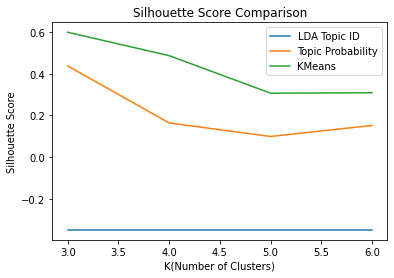

In [866]:
lda_sil = get_silhouette_list(sv_dt,lda_topic_clusters)
tp_sil = get_silhouette_list(sv_dt,topic_prob_clusters)
km_sil = get_silhouette_list(sv_dt,kmeans_cluster_dict)
plt.plot(list(kmeans_cluster_dict.keys()),lda_sil,label='LDA Topic ID')
plt.plot(list(kmeans_cluster_dict.keys()),tp_sil,label='Topic Probability')
plt.plot(list(kmeans_cluster_dict.keys()),km_sil,label='KMeans')
plt.legend(loc="upper right")
plt.xlabel('K(Number of Clusters)')
plt.ylabel('Silhouette Score')
plt.title("Silhouette Score Comparison")
plt.savefig("5", bbox_inches='tight')

## Semantic Evaluation Using Palmetto API

The coherence measures implemented with Palmetto mainly built on a reference index. This index is used to derive counts for the calculation of the coehrence values. These values can be used to measure the human interpretability of topics based on the topics' top words. It should be noted that the preprocessing of the index has an influence on the results.

In [688]:
kw_model = KeyBERT('all-MiniLM-L6-v2')
raw_dt['kp'] = kw_model.extract_keywords(raw_dt["Text"].to_list(), keyphrase_ngram_range=(2, 2), stop_words='english',
                              use_maxsum=True, nr_candidates=30, top_n=5)
# raw_dt['Cluster'] = clusters_2

200it [00:00, 427.95it/s]


In [ ]:
sv_df = pd.DataFrame(sv_dt)

In [844]:
#Find 3 most closest records to each cluster centers and extract their keyphrases
def get_coherence(sv_df, cluster_to_check):
    explanations = []
    sv_df['Cluster'] = cluster_to_check
    closest_pt_idx = {}
    for iclust in range(0, len(set(cluster_to_check))):
        cluster_pts = np.array(sv_df[sv_df['Cluster'] == iclust].iloc[:,:-1])
        cluster_pts_indices = sv_df[sv_df['Cluster'] == iclust].index
        cluster_cen = centers[iclust]
        idxs = (np.array([euclidean(np.array(sv_df.loc[idx][:-1]), cluster_cen) for idx in cluster_pts_indices])).argsort()[:10]
        closest_pt_idx[iclust] = list(cluster_pts_indices[idxs])

    kp_list = [i[0][0] for i in list(raw_dt['kp'])]

    dd = defaultdict()
    for i in range(0, len(closest_pt_idx.keys())):
        lst = []
        for j in closest_pt_idx[i]:
            lst.append(kp_list[j])
        dd[i] = lst
    words_list = []
    for i in dict(dd).keys():
        words_list.append(list(set(dd[i])))
        w = []
    for i in words_list:
        w.extend([c.split(" ") for c in i])
    palmetto = Palmetto()
    scores = []
    for words in w:
        scores.append(palmetto.get_coherence(words[:9]))
    explanations.append(dd)
    return np.mean(scores)

In [881]:
lda_cohe_scores = []
for clus in list(lda_topic_clusters.values()):
    co_score = get_coherence(sv_df=sv_df,cluster_to_check=clus)
    lda_cohe_scores.append(co_score)

In [882]:
tp_cohe_scores = []
for clus in list(topic_prob_clusters.values()):
    co_score = get_coherence(sv_df=sv_df,cluster_to_check=clus)
    tp_cohe_scores.append(co_score)

In [883]:
km_cohe_scores = []
for clus in list(kmeans_cluster_dict.values()):
    co_score = get_coherence(sv_df=sv_df,cluster_to_check=clus)
    km_cohe_scores.append(co_score)
    

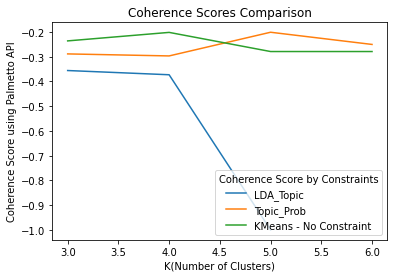

In [884]:
plt.plot(list(kmeans_cluster_dict.keys()),lda_cohe_scores,label='LDA_Topic')
plt.plot(list(kmeans_cluster_dict.keys()),tp_cohe_scores,label='Topic_Prob')
plt.plot(list(kmeans_cluster_dict.keys()),km_cohe_scores,label='KMeans - No Constraint')
plt.legend(loc="lower right",title="Coherence Score by Constraints")
plt.xlabel('K(Number of Clusters)')
plt.ylabel('Coherence Score using Palmetto API')
plt.title("Coherence Scores Comparison")
plt.savefig("6", bbox_inches='tight')

## Feature Selection / Importance

In [893]:
wvec_emb_data = Data.iloc [:, :300]

In [894]:
wvec_emb_data = Data.iloc [:, :300]

In [895]:
tfidf_data = Data.iloc [:, 300:10300]

In [896]:
tfidf_data_5000 = Data.iloc [:, 300:5300]

In [897]:
svd = TruncatedSVD(n_components=200, n_iter=7, random_state=42)
wvec_emb_data_200 = pd.DataFrame(svd.fit_transform(wvec_emb_data))

In [898]:
svd = TruncatedSVD(n_components=200, n_iter=7, random_state=42)
kp_data_200 =pd.DataFrame( svd.fit_transform(kp_data))

In [899]:
kp_data = Data.iloc[:, 10300:-1]

In [900]:
from copkmeans.cop_kmeans import cop_kmeans
from sklearn.metrics import silhouette_score
from collections import defaultdict
wvec_clusters_200 = defaultdict(int)
tfidf_clusters_5000 =  defaultdict(int)
kp_clusters_200 =  defaultdict(int)
wvec_clusters= defaultdict(int)
tfidf_clusters=  defaultdict(int)
kp_clusters =  defaultdict(int)
for i in range(0,5):
    clusters_wvec_emb, centers = cop_kmeans(dataset=svd.fit_transform(wvec_emb_data_200), k=6, ml=ml,cl=cl)
    wvec_clusters_200[i] = clusters_wvec_emb
    clusters_tfidf, centers = cop_kmeans(dataset=svd.fit_transform(tfidf_data_5000), k=6, ml=ml,cl=cl)
    tfidf_clusters_5000[i] = clusters_tfidf
    clusters_kp, centers = cop_kmeans(dataset=svd.fit_transform(kp_data_200), k=6, ml=ml,cl=cl)
    kp_clusters_200[i] = clusters_kp
    clusters_wvec_emb, centers = cop_kmeans(dataset=svd.fit_transform(wvec_emb_data), k=6, ml=ml,cl=cl)
    wvec_clusters[i] = clusters_wvec_emb
    clusters_tfidf, centers = cop_kmeans(dataset=svd.fit_transform(tfidf_data), k=6, ml=ml,cl=cl)
    tfidf_clusters[i] = clusters_tfidf
    clusters_kp, centers = cop_kmeans(dataset=svd.fit_transform(kp_data), k=6, ml=ml,cl=cl)
    kp_clusters[i] = clusters_kp

W2VEC_200: 0.11718847945951669, WVEC: 0.11155777801516276, tfidf_5000: 0.009479082343119933, tfidf_10000: 0.012027539601821263, kp_200: 0.010760405100882053 kp384: 0.012560034170746803


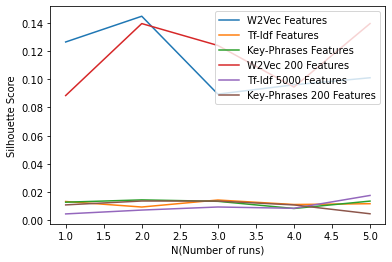

In [913]:
wvec_sil = get_silhouette_list(wvec_emb_data, wvec_clusters)
tfidf_sil = get_silhouette_list(tfidf_data,tfidf_clusters)
kp_sil = get_silhouette_list(kp_data,kp_clusters)
wvec_200_sil = get_silhouette_list(wvec_emb_data_200, wvec_clusters_200)
tfidf_5000_sil = get_silhouette_list(tfidf_data_5000,tfidf_clusters_5000)
kp_200_sil = get_silhouette_list(kp_data_200,kp_clusters_200)
plt.plot([i for i in range(1,6)],wvec_sil,label='W2Vec Features')
plt.plot([i for i in range(1,6)],tfidf_sil,label='Tf-Idf Features')
plt.plot([i for i in range(1,6)],kp_sil,label='Key-Phrases Features')
plt.plot([i for i in range(1,6)],wvec_200_sil,label='W2Vec 200 Features')
plt.plot([i for i in range(1,6)],tfidf_5000_sil,label='Tf-Idf 5000 Features')
plt.plot([i for i in range(1,6)],kp_200_sil,label='Key-Phrases 200 Features')
plt.xlabel('N(Number of runs)')
plt.ylabel('Silhouette Score')
plt.legend(loc="upper right")

plt.savefig("7", bbox_inches='tight')


print(f"W2VEC_200: {np.mean(wvec_200_sil)}, WVEC: {np.mean(wvec_sil)}, tfidf_5000: {np.mean(tfidf_5000_sil)}, tfidf_10000: {np.mean(tfidf_sil)}, kp_200: {np.mean(kp_200_sil)} kp384: {np.mean(kp_sil)}")

In [845]:
wvec_cohe_scores = []
for clus in list(wvec_clusters.values()):
    co_score = get_coherence(sv_df=sv_df,cluster_to_check=clus)
    wvec_cohe_scores.append(co_score)

In [846]:
tfidf_cohe_scores = []
for clus in list(tfidf_clusters.values()):
    co_score = get_coherence(sv_df=sv_df,cluster_to_check=clus)
    tfidf_cohe_scores.append(co_score)

In [847]:
kp_cohe_scores = []
for clus in list(kp_clusters.values()):
    co_score = get_coherence(sv_df=sv_df,cluster_to_check=clus)
    kp_cohe_scores.append(co_score)

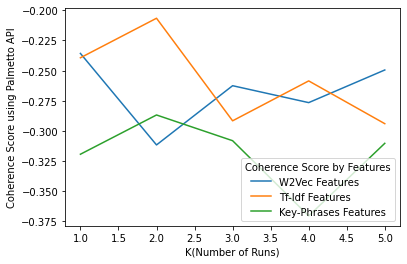

In [878]:
plt.plot([x+1 for x in list(wvec_clusters.keys())],wvec_cohe_scores,label='W2Vec Features')
plt.plot([x+1 for x in list(tfidf_clusters.keys())],tfidf_cohe_scores,label='Tf-Idf Features')
plt.plot([x+1 for x in list(kp_clusters.keys())],kp_cohe_scores,label='Key-Phrases Features')
plt.legend(loc="lower right",title="Coherence Score by Features")
plt.xlabel('K(Number of Runs)')
plt.ylabel('Coherence Score using Palmetto API')
plt.savefig("8", bbox_inches='tight')

In [800]:
raw_dt["Cluster"] = clusters_2

In [968]:
pd.set_option('display.max_colwidth', 30)

In [719]:
kw_per_cluster = defaultdict(int)

for c in set(clusters_2):
    clustered_docs = raw_dt[raw_dt["Cluster"]==c]
    #print(len(clustered_docs))
    current_cluster_words = []
    for doc in range(len(clustered_docs)):
        current_doc_list = clustered_docs.iloc[doc]["kp"]
        current_cluster_words.extend([i[0] for i in current_doc_list])
    kw_per_cluster["cl"+str(c)]=current_cluster_words
   

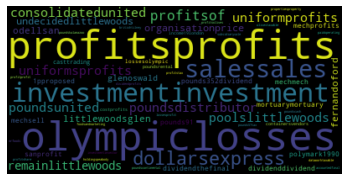

In [969]:
wordcloud = WordCloud().generate("".join(kw_per_cluster["cl0"]))
# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.savefig("a")


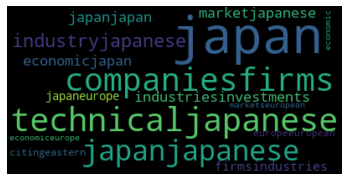

In [970]:
wordcloud = WordCloud().generate("".join(kw_per_cluster["cl1"]))

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.savefig("b")

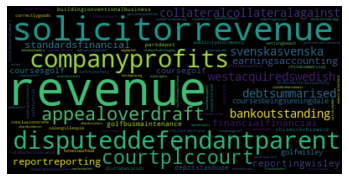

In [971]:
wordcloud = WordCloud().generate("".join(kw_per_cluster["cl2"]))

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.savefig("c")

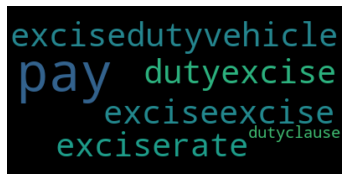

In [972]:
wordcloud = WordCloud().generate("".join(kw_per_cluster["cl3"]))

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

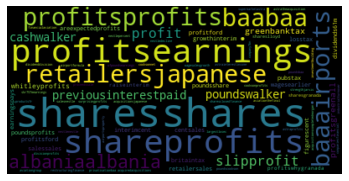

In [973]:
wordcloud = WordCloud().generate("".join(kw_per_cluster["cl4"]))

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

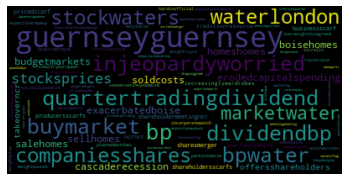

In [974]:
wordcloud = WordCloud().generate("".join(kw_per_cluster["cl5"]))

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

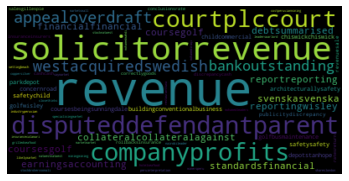

In [975]:
wordcloud = WordCloud().generate("".join(kw_per_cluster["cl2"]))

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

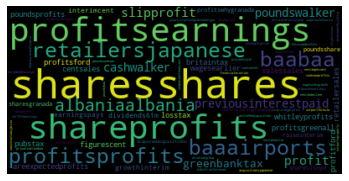

In [976]:
wordcloud = WordCloud().generate("".join(kw_per_cluster["cl4"]))

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

## Explainability with constraints

In [977]:
pd.set_option('display.max_colwidth', None)
exp_dt = raw_dt.iloc[[14,40,19,186, 167, 77, 21, 140]]

In [978]:
exp_cl_0 = exp_dt[exp_dt["Cluster"] == 2]

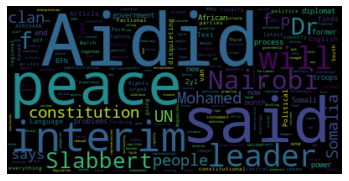

In [979]:
wordcloud = WordCloud().generate("".join(exp_dt[exp_dt["Cluster"] == 2]["Text"]))
# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.savefig("cc")

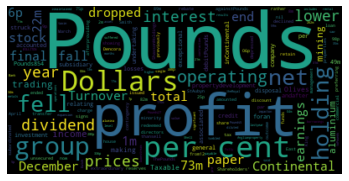

In [980]:
wordcloud = WordCloud().generate("".join(exp_dt[exp_dt["Cluster"] == 0]["Text"]))
# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.savefig("dd")